# **Homework 7 - Bert (Question Answering)**

If you have any questions, feel free to email us at mlta-2022-spring@googlegroups.com



Slide:    [Link](https://docs.google.com/presentation/d/1H5ZONrb2LMOCixLY7D5_5-7LkIaXO6AGEaV2mRdTOMY/edit?usp=sharing)　Kaggle: [Link](https://www.kaggle.com/c/ml2022spring-hw7)　Data: [Link](https://drive.google.com/uc?id=1AVgZvy3VFeg0fX-6WQJMHPVrx3A-M1kb)




## Task description
- Chinese Extractive Question Answering
  - Input: Paragraph + Question
  - Output: Answer

- Objective: Learn how to fine tune a pretrained model on downstream task using transformers

- Todo
    - Fine tune a pretrained chinese BERT model
    - Change hyperparameters (e.g. doc_stride)
    - Apply linear learning rate decay
    - Try other pretrained models
    - Improve preprocessing
    - Improve postprocessing
- Training tips
    - Automatic mixed precision
    - Gradient accumulation
    - Ensemble

- Estimated training time (tesla t4 with automatic mixed precision enabled)
    - Simple: 8mins
    - Medium: 8mins
    - Strong: 25mins
    - Boss: 2.5hrs
  

## Download Dataset

In [ ]:
# For this HW, K80 < P4 < T4 < P100 <= T4(fp16) < V100
!nvidia-smi

Tue Apr 19 06:49:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Download link 1
!gdown --id '1AVgZvy3VFeg0fX-6WQJMHPVrx3A-M1kb' --output hw7_data.zip

# Download Link 2 (if the above link fails) 
# !gdown --id '1qwjbRjq481lHsnTrrF4OjKQnxzgoLEFR' --output hw7_data.zip

# Download Link 3 (if the above link fails) 
# !gdown --id '1QXuWjNRZH6DscSd6QcRER0cnxmpZvijn' --output hw7_data.zip

!unzip -o hw7_data.zip

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1AVgZvy3VFeg0fX-6WQJMHPVrx3A-M1kb
To: /content/hw7_data.zip
100% 9.57M/9.57M [00:00<00:00, 21.4MB/s]
Archive:  hw7_data.zip
  inflating: hw7_dev.json            
  inflating: hw7_test.json           
  inflating: hw7_train.json          


## Install transformers

Documentation for the toolkit:　https://huggingface.co/transformers/

In [ ]:
# You are allowed to change version of transformers or use other toolkits
%%capture
!pip install transformers==4.5.0

## Import Packages

In [ ]:
import json
import numpy as np
import random
import torch
from torch.utils.data import DataLoader, Dataset 
from transformers import AdamW, BertForQuestionAnswering, BertTokenizerFast

from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

# Fix random seed for reproducibility
def same_seeds(seed):
	  torch.manual_seed(seed)
	  if torch.cuda.is_available():
		    torch.cuda.manual_seed(seed)
		    torch.cuda.manual_seed_all(seed)
	  np.random.seed(seed)
	  random.seed(seed)
	  torch.backends.cudnn.benchmark = False
	  torch.backends.cudnn.deterministic = True
same_seeds(0)

In [ ]:
# Change "fp16_training" to True to support automatic mixed precision training (fp16)	
fp16_training = True

if fp16_training:
    !pip install accelerate==0.2.0
    from accelerate import Accelerator
    accelerator = Accelerator(fp16=True)
    device = accelerator.device

# Documentation for the toolkit:  https://huggingface.co/docs/accelerate/

## Load Model and Tokenizer




 

In [ ]:
# model = BertForQuestionAnswering.from_pretrained("bert-base-chinese").to(device)
# tokenizer = BertTokenizerFast.from_pretrained("bert-base-chinese")

model = BertForQuestionAnswering.from_pretrained("hfl/chinese-macbert-large").to(device)
tokenizer = BertTokenizerFast.from_pretrained("hfl/chinese-macbert-large")

# You can safely ignore the warning message (it pops up because new prediction heads for QA are initialized randomly)

Some weights of the model checkpoint at hfl/chinese-macbert-large were not used when initializing BertForQuestionAnswering: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the

## Read Data

- Training set: 31690 QA pairs
- Dev set: 4131  QA pairs
- Test set: 4957  QA pairs

- {train/dev/test}_questions:	
  - List of dicts with the following keys:
   - id (int)
   - paragraph_id (int)
   - question_text (string)
   - answer_text (string)
   - answer_start (int)
   - answer_end (int)
- {train/dev/test}_paragraphs: 
  - List of strings
  - paragraph_ids in questions correspond to indexs in paragraphs
  - A paragraph may be used by several questions 

In [ ]:
def read_data(file):
    with open(file, 'r', encoding="utf-8") as reader:
        data = json.load(reader)
    return data["questions"], data["paragraphs"]

train_questions, train_paragraphs = read_data("hw7_train.json")
dev_questions, dev_paragraphs = read_data("hw7_dev.json")
test_questions, test_paragraphs = read_data("hw7_test.json")

## Tokenize Data

In [ ]:
# Tokenize questions and paragraphs separately
# 「add_special_tokens」 is set to False since special tokens will be added when tokenized questions and paragraphs are combined in datset __getitem__ 

train_questions_tokenized = tokenizer([train_question["question_text"] for train_question in train_questions], add_special_tokens=False)
dev_questions_tokenized = tokenizer([dev_question["question_text"] for dev_question in dev_questions], add_special_tokens=False)
test_questions_tokenized = tokenizer([test_question["question_text"] for test_question in test_questions], add_special_tokens=False) 

train_paragraphs_tokenized = tokenizer(train_paragraphs, add_special_tokens=False)
dev_paragraphs_tokenized = tokenizer(dev_paragraphs, add_special_tokens=False, return_offsets_mapping=True)
test_paragraphs_tokenized = tokenizer(test_paragraphs, add_special_tokens=False, return_offsets_mapping=True)

# You can safely ignore the warning message as tokenized sequences will be futher processed in datset __getitem__ before passing to model

## Dataset and Dataloader
random select: https://zhuanlan.zhihu.com/p/398953990

In [ ]:
class QA_Dataset(Dataset):
    def __init__(self, split, questions, tokenized_questions, tokenized_paragraphs):
        self.split = split
        self.questions = questions
        self.tokenized_questions = tokenized_questions
        self.tokenized_paragraphs = tokenized_paragraphs
        # self.max_question_len = 40
        # self.max_paragraph_len = 150
        self.max_question_len = 100
        self.max_paragraph_len = 400
        
        ##### TODO: Change value of doc_stride #####
        # self.doc_stride = 150
        self.doc_stride = 80

        # Input sequence length = [CLS] + question + [SEP] + paragraph + [SEP]
        self.max_seq_len = 1 + self.max_question_len + 1 + self.max_paragraph_len + 1

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        question = self.questions[idx]
        tokenized_question = self.tokenized_questions[idx]
        tokenized_paragraph = self.tokenized_paragraphs[question["paragraph_id"]]

        ##### TODO: Preprocessing #####
        # Hint: How to prevent model from learning something it should not learn

        if self.split == "train":
            # Convert answer's start/end positions in paragraph_text to start/end positions in tokenized_paragraph  
            answer_start_token = tokenized_paragraph.char_to_token(question["answer_start"])
            answer_end_token = tokenized_paragraph.char_to_token(question["answer_end"])

            # A single window is obtained by slicing the portion of paragraph containing the answer
            mid = (answer_start_token + answer_end_token) // 2
            answer_length = answer_end_token - answer_start_token + 1
            if answer_length // 2 < self.max_paragraph_len - answer_length // 2:
                rnd = random.randint(answer_length // 2, self.max_paragraph_len - answer_length // 2)
            else:
                rnd = self.max_paragraph_len // 2
            paragraph_start = max(0, min(mid - rnd, len(tokenized_paragraph) - self.max_paragraph_len))
            paragraph_end = paragraph_start + self.max_paragraph_len
            # paragraph_start = max(0, min(mid - self.max_paragraph_len // 2, len(tokenized_paragraph) - self.max_paragraph_len))
            # paragraph_end = paragraph_start + self.max_paragraph_len
            
            # Slice question/paragraph and add special tokens (101: CLS, 102: SEP)
            input_ids_question = [101] + tokenized_question.ids[:self.max_question_len] + [102] 
            input_ids_paragraph = tokenized_paragraph.ids[paragraph_start : paragraph_end] + [102]		
            
            # Convert answer's start/end positions in tokenized_paragraph to start/end positions in the window  
            answer_start_token += len(input_ids_question) - paragraph_start
            answer_end_token += len(input_ids_question) - paragraph_start
            
            # Pad sequence and obtain inputs to model 
            input_ids, token_type_ids, attention_mask = self.padding(input_ids_question, input_ids_paragraph)
            return torch.tensor(input_ids), torch.tensor(token_type_ids), torch.tensor(attention_mask), answer_start_token, answer_end_token

        # Validation/Testing
        else:
            input_ids_list, token_type_ids_list, attention_mask_list = [], [], []
            
            # Paragraph is split into several windows, each with start positions separated by step "doc_stride"
            for i in range(0, len(tokenized_paragraph), self.doc_stride):
                
                # Slice question/paragraph and add special tokens (101: CLS, 102: SEP)
                input_ids_question = [101] + tokenized_question.ids[:self.max_question_len] + [102]
                input_ids_paragraph = tokenized_paragraph.ids[i : i + self.max_paragraph_len] + [102]
                
                # Pad sequence and obtain inputs to model
                input_ids, token_type_ids, attention_mask = self.padding(input_ids_question, input_ids_paragraph)
                
                input_ids_list.append(input_ids)
                token_type_ids_list.append(token_type_ids)
                attention_mask_list.append(attention_mask)
            
            return torch.tensor(input_ids_list), torch.tensor(token_type_ids_list), torch.tensor(attention_mask_list)

    def padding(self, input_ids_question, input_ids_paragraph):
        # Pad zeros if sequence length is shorter than max_seq_len
        padding_len = self.max_seq_len - len(input_ids_question) - len(input_ids_paragraph)
        # Indices of input sequence tokens in the vocabulary
        input_ids = input_ids_question + input_ids_paragraph + [0] * padding_len
        # Segment token indices to indicate first and second portions of the inputs. Indices are selected in [0, 1]
        token_type_ids = [0] * len(input_ids_question) + [1] * len(input_ids_paragraph) + [0] * padding_len
        # Mask to avoid performing attention on padding token indices. Mask values selected in [0, 1]
        attention_mask = [1] * (len(input_ids_question) + len(input_ids_paragraph)) + [0] * padding_len
        
        return input_ids, token_type_ids, attention_mask

train_set = QA_Dataset("train", train_questions, train_questions_tokenized, train_paragraphs_tokenized)
dev_set = QA_Dataset("dev", dev_questions, dev_questions_tokenized, dev_paragraphs_tokenized)
test_set = QA_Dataset("test", test_questions, test_questions_tokenized, test_paragraphs_tokenized)

train_batch_size = 4
doc_stride = train_set.doc_stride

# Note: Do NOT change batch size of dev_loader / test_loader !
# Although batch size=1, it is actually a batch consisting of several windows from the same QA pair
train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True, pin_memory=True)
dev_loader = DataLoader(dev_set, batch_size=1, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, pin_memory=True)

## Function for Evaluation
offsets: https://huggingface.co/course/chapter6/3

In [ ]:
dev_paragraphs_offsets = dev_paragraphs_tokenized["offset_mapping"]
test_paragraphs_offsets = test_paragraphs_tokenized["offset_mapping"]

In [ ]:
def index_before_tokenize_dev(idx, start_index, end_index, k):
    start = start_index - len(dev_questions[idx]['question_text']) - 2 + k * doc_stride
    end = end_index - len(dev_questions[idx]['question_text']) - 2 + k * doc_stride
    
    new_start = dev_paragraphs_offsets[dev_questions[idx]['paragraph_id']][start]
    new_end = dev_paragraphs_offsets[dev_questions[idx]['paragraph_id']][end]
    return new_start[0], new_end[1]

In [ ]:
def index_before_tokenize_test(idx, start_index, end_index, k):
    start = start_index - len(test_questions[idx]['question_text']) - 2 + k * doc_stride
    end = end_index - len(test_questions[idx]['question_text']) - 2 + k * doc_stride
    
    new_start = test_paragraphs_offsets[test_questions[idx]['paragraph_id']][start]
    new_end = test_paragraphs_offsets[test_questions[idx]['paragraph_id']][end]
    return new_start[0], new_end[1]

In [ ]:
def evaluate(data, output, idx, split):
    ##### TODO: Postprocessing #####
    # There is a bug and room for improvement in postprocessing 
    # Hint: Open your prediction file to see what is wrong 
    
    answer = ''
    max_prob = float('-inf')
    num_of_windows = data[0].shape[1]
    
    for k in range(num_of_windows):
        # Obtain answer by choosing the most probable start position / end position
        start_prob, start_index = torch.max(output.start_logits[k], dim=0)
        end_prob, end_index = torch.max(output.end_logits[k], dim=0)
        
        # Probability of answer is calculated as sum of start_prob and end_prob
        prob = start_prob + end_prob
        
        # Replace answer if calculated probability is larger than previous windows
        if (prob > max_prob) and (end_index > start_index):
            max_prob = prob
            # Convert tokens to chars (e.g. [1920, 7032] --> "大 金")
            answer = tokenizer.decode(data[0][0][k][start_index : end_index + 1])
            record_k = k

        if answer.find('[UNK]') != -1:
            if split == 'dev':
                new_start, new_end = index_before_tokenize_dev(idx, start_index, end_index, record_k)
                answer = dev_paragraphs[dev_questions[idx]['paragraph_id']][new_start:new_end]

            if split == 'test':
                new_start, new_end = index_before_tokenize_test(idx, start_index, end_index, record_k)
                answer = test_paragraphs[test_questions[idx]['paragraph_id']][new_start:new_end]
            
    
    # Remove spaces in answer (e.g. "大 金" --> "大金")
    answer = answer.replace('[CLS]','')
    answer = answer[answer.find('[SEP]')+1:]  # auto leftest index             
    return answer.replace(' ','')

## Schedule
Ref: https://huggingface.co/transformers/v2.0.0/_modules/transformers/optimization.html

In [ ]:
from torch.optim.lr_scheduler import LambdaLR
class WarmupLinearSchedule(LambdaLR):
    """ Linear warmup and then linear decay.
        Linearly increases learning rate from 0 to 1 over `warmup_steps` training steps.
        Linearly decreases learning rate from 1. to 0. over remaining `t_total - warmup_steps` steps.
    """
    def __init__(self, optimizer, warmup_steps, t_total, last_epoch=-1):
        self.warmup_steps = warmup_steps
        self.t_total = t_total
        super(WarmupLinearSchedule, self).__init__(optimizer, self.lr_lambda, last_epoch=last_epoch)

    def lr_lambda(self, step):
        if step < self.warmup_steps:
            return float(step) / float(max(1, self.warmup_steps))
        return max(0.0, float(self.t_total - step) / float(max(1.0, self.t_total - self.warmup_steps)))

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


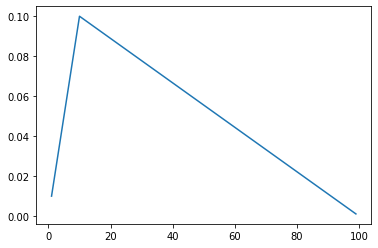

In [ ]:
import matplotlib.pyplot as plt
optimizer =  AdamW(model.parameters(), lr = 1e-1)
scheduler = WarmupLinearSchedule(optimizer, warmup_steps = 10, t_total = 100)
lr_tab = []
for epoch in range(1, 100):
    scheduler.step()
    lr_tab.append(scheduler.get_last_lr()[0])
plt.plot(np.arange(1, 100), lr_tab)

## Training
Gradient Accumulation: https://cowarder.site/2019/10/29/Gradient-Accumulation//<br>
mini batch size = 4<br>
Actual batch size = 8 * mini batch size = 32

In [ ]:
num_epoch = 3
validation = True
logging_step = 500
learning_rate = 5e-5
accumulation_steps = 8
total_steps = len(train_loader) * num_epoch
optimizer = AdamW(model.parameters(), lr=learning_rate)
scheduler = WarmupLinearSchedule(optimizer, warmup_steps=500, t_total=total_steps)

if fp16_training:
    model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader) 

model.train()

print("Start Training ...")

for epoch in range(num_epoch):
    step = 1
    train_loss = train_acc = 0
    
    # for data in tqdm(train_loader):
    for batch_idx, data in enumerate(tqdm(train_loader)):
        # Load all data into GPU
        data = [i.to(device) for i in data]
        
        # Model inputs: input_ids, token_type_ids, attention_mask, start_positions, end_positions (Note: only "input_ids" is mandatory)
        # Model outputs: start_logits, end_logits, loss (return when start_positions/end_positions are provided)  
        output = model(input_ids=data[0], token_type_ids=data[1], attention_mask=data[2], start_positions=data[3], end_positions=data[4])

        # Choose the most probable start position / end position
        start_index = torch.argmax(output.start_logits, dim=1)
        end_index = torch.argmax(output.end_logits, dim=1)
        
        # Prediction is correct only if both start_index and end_index are correct
        train_acc += ((start_index == data[3]) & (end_index == data[4])).float().mean()
        train_loss += output.loss / accumulation_steps

        
        if fp16_training:
            accelerator.backward(output.loss)
        else:
            output.loss.backward()
        
        if ((batch_idx + 1) % accumulation_steps == 0) or (batch_idx + 1 == len(train_loader)):
            optimizer.step()
            optimizer.zero_grad()
        step += 1

        ##### TODO: Apply linear learning rate decay #####
        scheduler.step()
        
        
        # Print training loss and accuracy over past logging step
        if step % logging_step == 0:
            print(f"Epoch {epoch + 1} | Step {step} | loss = {train_loss.item() / logging_step:.3f}, acc = {train_acc / logging_step:.3f}, lr = {scheduler.get_last_lr()[0]:.5f}")
            train_loss = train_acc = 0

    if validation:
        print("Evaluating Dev Set ...")
        model.eval()
        with torch.no_grad():
            dev_acc = 0
            for i, data in enumerate(tqdm(dev_loader)):
                output = model(input_ids=data[0].squeeze(dim=0).to(device), token_type_ids=data[1].squeeze(dim=0).to(device),
                       attention_mask=data[2].squeeze(dim=0).to(device))
                dev_acc += evaluate(data, output, i, 'dev') == dev_questions[i]["answer_text"]
            print(f"Validation | Epoch {epoch + 1} | acc = {dev_acc / len(dev_loader):.3f}")
        model.train()

# Save a model and its configuration file to the directory 「saved_model」 
# i.e. there are two files under the direcory 「saved_model」: 「pytorch_model.bin」 and 「config.json」
# Saved model can be re-loaded using 「model = BertForQuestionAnswering.from_pretrained("saved_model")」
print("Saving Model ...")
model_save_dir = "saved_model" 
model.save_pretrained(model_save_dir)

Start Training ...


  0%|          | 0/7923 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch 1 | Step 500 | loss = 0.395, acc = 0.311, lr = 0.00005
Epoch 1 | Step 1000 | loss = 0.109, acc = 0.681, lr = 0.00005
Epoch 1 | Step 1500 | loss = 0.101, acc = 0.707, lr = 0.00005
Epoch 1 | Step 2000 | loss = 0.090, acc = 0.747, lr = 0.00005
Epoch 1 | Step 2500 | loss = 0.080, acc = 0.754, lr = 0.00005
Epoch 1 | Step 3000 | loss = 0.087, acc = 0.731, lr = 0.00004
Epoch 1 | Step 3500 | loss = 0.081, acc = 0.751, lr = 0.00004
Epoch 1 | Step 4000 | loss = 0.071, acc = 0.769, lr = 0.00004
Epoch 1 | Step 4500 | loss = 0.071, acc = 0.777, lr = 0.00004
Epoch 1 | Step 5000 | loss = 0.080, acc = 0.749, lr = 0.00004
Epoch 1 | Step 5500 | loss = 0.067, acc = 0.779, lr = 0.00004
Epoch 1 | Step 6000 | loss = 0.070, acc = 0.783, lr = 0.00004
Epoch 1 | Step 6500 | loss = 0.076, acc = 0.775, lr = 0.00004
Epoch 1 | Step 7000 | loss = 0.085, acc = 0.748, lr = 0.00004
Epoch 1 | Step 7500 | loss = 0.079, acc = 0.755, lr = 0.00003
Evaluating Dev Set ...


  0%|          | 0/4131 [00:00<?, ?it/s]

Validation | Epoch 1 | acc = 0.779


  0%|          | 0/7923 [00:00<?, ?it/s]

Epoch 2 | Step 500 | loss = 0.040, acc = 0.855, lr = 0.00003
Epoch 2 | Step 1000 | loss = 0.036, acc = 0.870, lr = 0.00003
Epoch 2 | Step 1500 | loss = 0.035, acc = 0.872, lr = 0.00003
Epoch 2 | Step 2000 | loss = 0.036, acc = 0.866, lr = 0.00003
Epoch 2 | Step 2500 | loss = 0.038, acc = 0.868, lr = 0.00003
Epoch 2 | Step 3000 | loss = 0.035, acc = 0.877, lr = 0.00003
Epoch 2 | Step 3500 | loss = 0.034, acc = 0.879, lr = 0.00003
Epoch 2 | Step 4000 | loss = 0.032, acc = 0.890, lr = 0.00003
Epoch 2 | Step 4500 | loss = 0.030, acc = 0.895, lr = 0.00002
Epoch 2 | Step 5000 | loss = 0.029, acc = 0.899, lr = 0.00002
Epoch 2 | Step 5500 | loss = 0.032, acc = 0.891, lr = 0.00002
Epoch 2 | Step 6000 | loss = 0.030, acc = 0.898, lr = 0.00002
Epoch 2 | Step 6500 | loss = 0.030, acc = 0.892, lr = 0.00002
Epoch 2 | Step 7000 | loss = 0.029, acc = 0.893, lr = 0.00002
Epoch 2 | Step 7500 | loss = 0.033, acc = 0.882, lr = 0.00002
Evaluating Dev Set ...


  0%|          | 0/4131 [00:00<?, ?it/s]

Validation | Epoch 2 | acc = 0.801


  0%|          | 0/7923 [00:00<?, ?it/s]

Epoch 3 | Step 500 | loss = 0.013, acc = 0.955, lr = 0.00002
Epoch 3 | Step 1000 | loss = 0.011, acc = 0.951, lr = 0.00001
Epoch 3 | Step 1500 | loss = 0.011, acc = 0.961, lr = 0.00001
Epoch 3 | Step 2000 | loss = 0.014, acc = 0.951, lr = 0.00001
Epoch 3 | Step 2500 | loss = 0.012, acc = 0.952, lr = 0.00001
Epoch 3 | Step 3000 | loss = 0.009, acc = 0.963, lr = 0.00001
Epoch 3 | Step 3500 | loss = 0.009, acc = 0.962, lr = 0.00001
Epoch 3 | Step 4000 | loss = 0.010, acc = 0.957, lr = 0.00001
Epoch 3 | Step 4500 | loss = 0.013, acc = 0.957, lr = 0.00001
Epoch 3 | Step 5000 | loss = 0.011, acc = 0.959, lr = 0.00001
Epoch 3 | Step 5500 | loss = 0.013, acc = 0.952, lr = 0.00001
Epoch 3 | Step 6000 | loss = 0.011, acc = 0.957, lr = 0.00000
Epoch 3 | Step 6500 | loss = 0.011, acc = 0.961, lr = 0.00000
Epoch 3 | Step 7000 | loss = 0.010, acc = 0.963, lr = 0.00000
Epoch 3 | Step 7500 | loss = 0.012, acc = 0.952, lr = 0.00000
Evaluating Dev Set ...


  0%|          | 0/4131 [00:00<?, ?it/s]

Validation | Epoch 3 | acc = 0.802
Saving Model ...


## Testing

In [ ]:
print("Evaluating Test Set ...")

result = []

model.eval()
with torch.no_grad():
    # for data in tqdm(test_loader):
    for i, data in enumerate(tqdm(test_loader)):
        output = model(input_ids=data[0].squeeze(dim=0).to(device), token_type_ids=data[1].squeeze(dim=0).to(device),
                       attention_mask=data[2].squeeze(dim=0).to(device))
        # eval_out = (data, output, doc_stride=100, paragraph=test_paragraphs[test_questions[-1]['paragraph_id']], paragraph_tokenized=test_paragraphs_tokenized[test_questions[-1]['paragraph_id']].tokens)
        result.append(evaluate(data, output, i, 'test'))
        # result.append(evaluate(data, output))

result_file = "result.csv"
with open(result_file, 'w') as f:	
	  f.write("ID,Answer\n")
	  for i, test_question in enumerate(test_questions):
        # Replace commas in answers with empty strings (since csv is separated by comma)
        # Answers in kaggle are processed in the same way
		    f.write(f"{test_question['id']},{result[i].replace(',','')}\n")

print(f"Completed! Result is in {result_file}")

Evaluating Test Set ...


  0%|          | 0/4957 [00:00<?, ?it/s]

Completed! Result is in result.csv
